In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Visualizing classification regions: logistic regression vs knn

## Auxiliary functions

In [2]:
def build_poly_features(X,degree):
    from itertools import combinations_with_replacement as comb_w_r
    from itertools import chain
    
    # number of datapoints (rows), number of features (columns)
    try:
        m,n = X.shape # this won't work if X is a vector (n=1 features)
    except: 
        m = len(X)
        n = 1
        X = X.reshape(m,1) #  
    
    # number of polynomial features
    combinations = chain.from_iterable(comb_w_r(range(n),i) for i in range(degree+1))
    n_poly = sum(1 for combination in combinations) 
    
    # polynomial features matrix
    X_poly = np.ones((m,n_poly))
    combinations = chain.from_iterable(comb_w_r(range(n),i) for i in range(degree+1))\
    
    
    for column_index, combination in enumerate(combinations):
        X_poly[:,column_index] = np.prod(X[:,combination],axis=1)
        
    return X_poly

In [3]:
# sigmoid
def sigmoid(t):
    return 1/(1+np.exp(-t))

# loss function
def logregression_cost(y,X,theta):
    m = len(y)
    p = sigmoid(X.dot(theta))
    return -(np.sum(y*np.log(p) + (1-y)*np.log(1-p)))

# logistic regression function
def logregression_GD(X,y,learning_rate, n_epochs=100):
    
    m,n = X.shape
    theta = np.random.randn(n)
    
    # initialize cost vector 
    cost = np.zeros(n_epochs)
    
    # gradient descent steps
    for epoch in range(n_epochs):
        gradient = X.T.dot(sigmoid(X.dot(theta))-y) # compute gradient
        theta = theta - learning_rate*gradient # Gradient Descent Step
        cost[epoch] = logregression_cost(y,X,theta) # compute the cost function
            
    results = {}
    results['theta'] = theta
    results['cost'] = cost
    return results

In [4]:
# this function builds a grid of points, and uses logistic regression to predict the class
# of the grid points
def plot_logregression_regions(X, y, theta, degree=0):
    from matplotlib.colors import ListedColormap
    # create a 100x100 meshgrid
    m_plot = 100
    x1 = np.linspace(X[:,0].min()-0.5, X[:,0].max()+0.5, m_plot)
    x2 = np.linspace(X[:,1].min()-0.5,X[:,1].max()+0.5, m_plot)
    X1, X2 = np.meshgrid(x1, x2) 
    X_plot = np.c_[X1.ravel(), X2.ravel()]
    
    X_plot_poly = build_poly_features(X_plot,degree=degree)

    # evaluate the logistic regression model at each point of the mesh grid    
    y_plot = sigmoid(X_plot_poly.dot(theta))
        
    # class prediction    
    y_plot[y_plot>=0.5]=1
    y_plot[y_plot<0.5]=0
    y_plot = y_plot.reshape(X1.shape)

    custom_cmap = ListedColormap(['C0','C1'])
    # contour map
    plt.figure(figsize=(12,5))
    plt.contourf(X1, X2, y_plot, alpha=0.3, cmap=custom_cmap)
    
    
    plt.plot(X[y==0,0],X[y==0,1],'o',label = 'class '+str(0))
    plt.plot(X[y==1,0],X[y==1,1],'o',label = 'class '+str(1))
    plt.legend(fontsize=15)

In [5]:
def knn_classifier(k,X,y,X_new, weights='uniform'):
    from sklearn.metrics import pairwise_distances
    
    # number of datapoints
    m,_ = X.shape
    m_new,_ = X_new.shape
    
    # classes and number of classes
    labels = np.unique(y)
    n_classes = len(labels)
    
    # distance matrix
    dist = pairwise_distances(X,X_new)
    
    # k nearest neighbor
    knn = np.argsort(dist,axis=0)[0:k]
    
    y_pred = np.zeros(m_new).astype(int)
    for i in range(m_new):
        # labels
        nearest_labels = y[knn[:,i]]
        # weights
        if weights=='uniform':
            w = np.ones(k)
        elif weights=='distance':
            w=1/dist[knn[:,i],i]
        else:
            print('weights not recognized: should be uniform or distance')
            return 
        # prediction
        y_pred[i] = np.argmax(np.bincount(nearest_labels, minlength=n_classes, weights=w))
    return y_pred, labels

In [6]:
def plot_knn_regions(X, y, k, weights='uniform'):
    from matplotlib.colors import ListedColormap
    # create a 50x50 meshgrid
    m_plot = 100
    x1 = np.linspace(X[:,0].min()-0.5, X[:,0].max()+0.5, m_plot)
    x2 = np.linspace(X[:,1].min()-0.5,X[:,1].max()+0.5, m_plot)
    X1, X2 = np.meshgrid(x1, x2) 
    X_plot = np.c_[X1.ravel(), X2.ravel()]
    

    # predictions based on knn 
    y_plot,_ = knn_classifier(k,X,y,X_plot, weights='uniform')
    y_plot = y_plot.reshape(X1.shape)

    custom_cmap = ListedColormap(['C0','C1'])
    # contour map
    plt.figure(figsize=(12,5))
    plt.contourf(X1, X2, y_plot, alpha=0.3, cmap=custom_cmap)
    
    
    plt.plot(X[y==0,0],X[y==0,1],'o',label = 'class '+str(0))
    plt.plot(X[y==1,0],X[y==1,1],'o',label = 'class '+str(1))
    plt.legend(fontsize=15)

## Example 1: the two-moons dataset

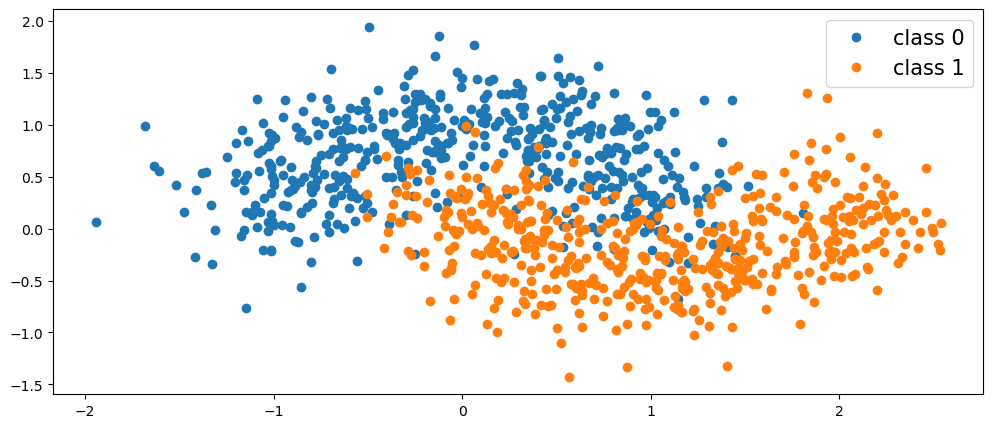

In [32]:
# run this cell to generate and visualize the dataset
from sklearn.datasets import make_moons
X,y = make_moons(n_samples=1000,noise=0.3)

plt.figure(figsize=(12,5))
plt.plot(X[y==0,0],X[y==0,1],'o',label = 'class '+str(0))
plt.plot(X[y==1,0],X[y==1,1],'o',label = 'class '+str(1))
plt.legend(fontsize=15)

Text(0, 0.5, 'cost')

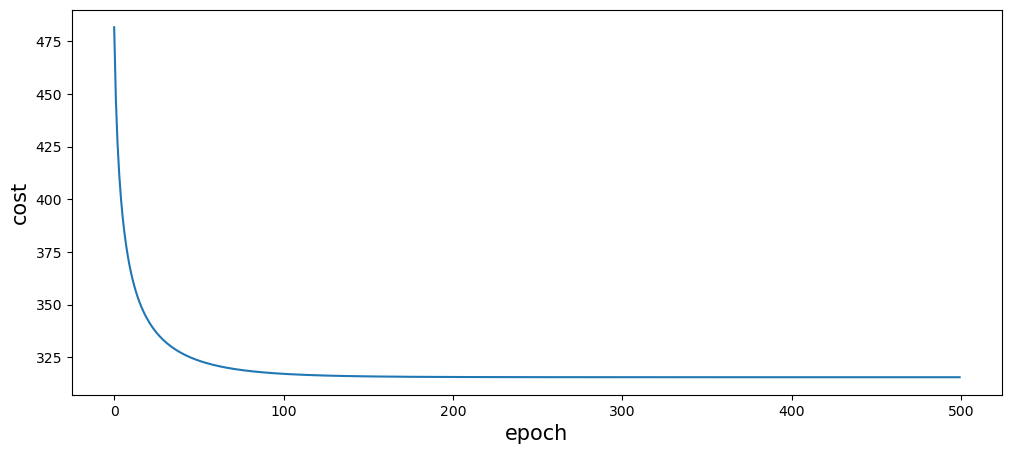

In [33]:
# build polynomial features
X_poly = build_poly_features(X,degree=1)
# gradient descent
results = logregression_GD(X_poly,y, 
                           learning_rate=0.001,
                           n_epochs = 500,
                          )
cost = results['cost']
plt.figure(figsize=(12,5))
plt.plot(cost)
plt.xlabel('epoch', fontsize=15)
plt.ylabel('cost', fontsize=15)

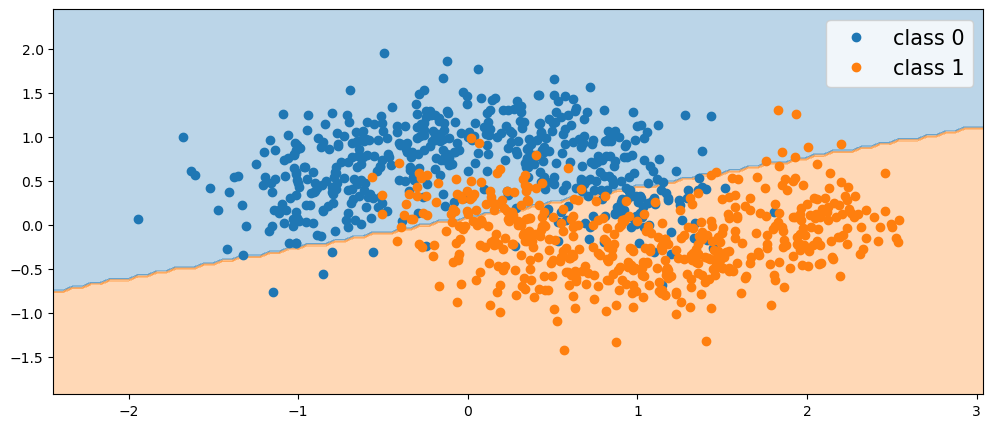

In [34]:
theta = results['theta']
plot_logregression_regions(X, y, theta, degree=1)

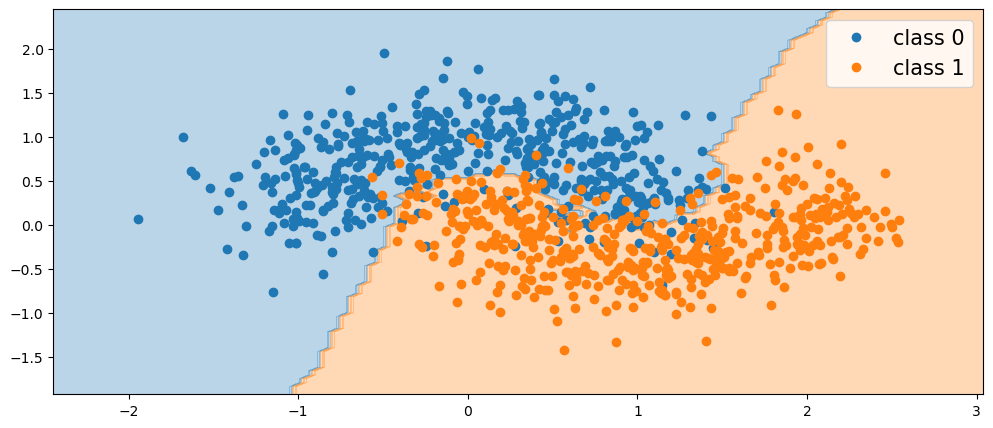

In [41]:
plot_knn_regions(X, y, k=10, weights='uniform')

Text(0, 0.5, 'cost')

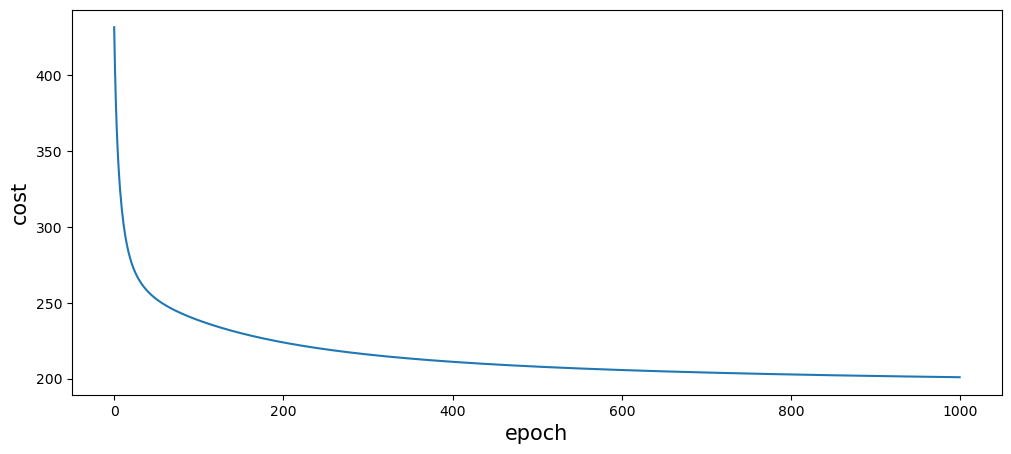

In [42]:
X_poly = build_poly_features(X,degree=3)
# gradient descent
results = logregression_GD(X_poly,y, 
                           learning_rate=0.001,
                           n_epochs = 1000,
                          )
cost = results['cost']
plt.figure(figsize=(12,5))
plt.plot(cost)
plt.xlabel('epoch', fontsize=15)
plt.ylabel('cost', fontsize=15)

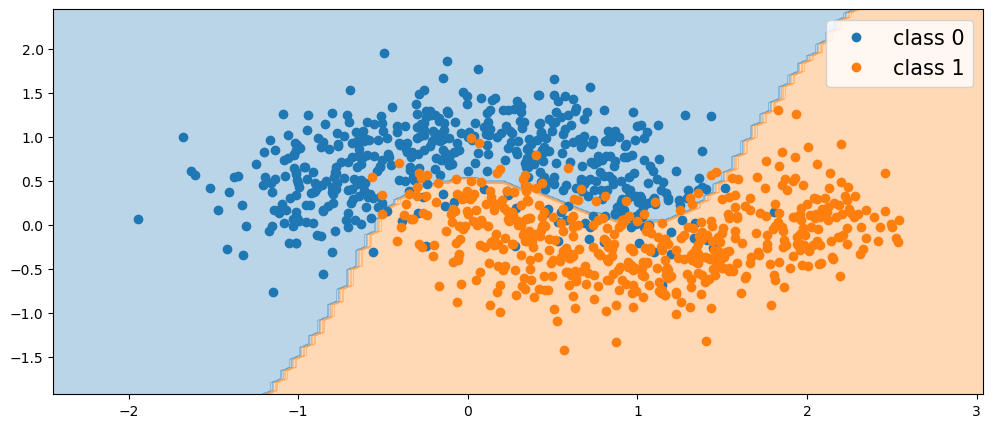

In [43]:
theta = results['theta']
plot_logregression_regions(X, y, theta, degree=3)

## Spirals dataset

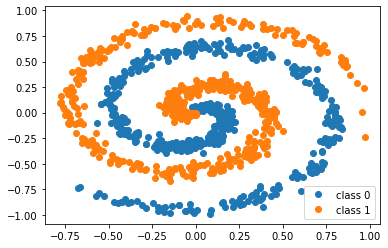

In [18]:
classes = 2
n_points = 500
noise = 0.35
radius = 10

X = np.zeros((n_points*classes, 2))
y = np.zeros(n_points*classes).astype('int')

for class_number in range(classes):
    ix = range(n_points*class_number, n_points*(class_number+1))
    r = np.linspace(0,1, n_points)
    t = np.linspace(class_number*radius, (class_number+1)*radius, n_points) + np.random.randn(n_points)*noise
    X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
    y[ix] = class_number
    
plt.plot(X[y==0,0],X[y==0,1],'o',label = 'class '+str(0))
plt.plot(X[y==1,0],X[y==1,1],'o',label = 'class '+str(1))
plt.legend()

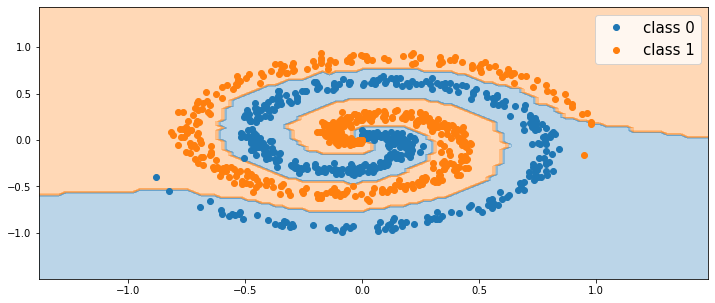

In [8]:
plot_knn_regions(X, y, k=10, weights='uniform')

Text(0, 0.5, 'cost')

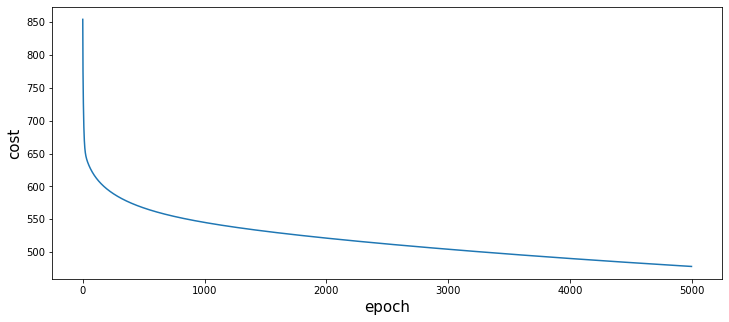

In [16]:
X_poly = build_poly_features(X,degree=10)
# gradient descent
results = logregression_GD(X_poly,y, 
                           learning_rate=0.002,
                           n_epochs = 5000,
                          )
cost = results['cost']
plt.figure(figsize=(12,5))
plt.plot(cost)
plt.xlabel('epoch', fontsize=15)
plt.ylabel('cost', fontsize=15)

C:\Users\javier.perez-alvaro\AppData\Local\Temp\ipykernel_13908\3624276669.py:3: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-t))


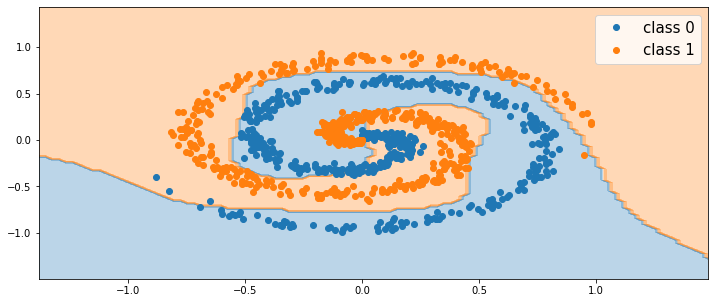

In [17]:
theta = results['theta']
plot_logregression_regions(X, y, theta, degree=10)